In [36]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime, date


from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

from datetime import datetime, date
import csv

mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.figsize'] = 4.8,3.2
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.fancybox'] = True


In [37]:
plot_spatialkde = False

# Read data

In [38]:
dataset = 'thefts'
#dataset = 'robberies'

if dataset == 'thefts':
    fulldf = pd.read_pickle('../data/theft-street.p')
    lowercase = 'thefts'
    uppercase = 'Thefts'
elif dataset == 'robberies':
    fulldf = pd.read_pickle('../data/robbery-street.p')
    lowercase = 'robberies'
    uppercase = 'Robberies'

In [39]:
# Add month and year columns
fulldf['month'] = fulldf.date.apply(lambda x: x.month)
fulldf['year'] = fulldf.date.apply(lambda x: x.year)

# Read weather data
weatherfull = pd.read_pickle(r"../data/noaa-weather-downtown-sf.p")


# Convert celsius to fahrenheit
def celsius2fahrenheit(T):
    return T * 1.8 + 32
weatherfull['TMAX'] = weatherfull['TMAX'].apply(celsius2fahrenheit)
weatherfull['TMIN'] = weatherfull['TMIN'].apply(celsius2fahrenheit)

# Join with weather
print 'merge with weather'
print 'before merge', fulldf.shape
fulldf = fulldf.merge(weatherfull,how="inner",left_on="date",right_on="DATE")
print 'after merge', fulldf.shape
print ''

# Filter out 2016 incidents
df = fulldf[fulldf.year < 2016]
print 'fulldf', fulldf.shape
print 'df 2003-2015', df.shape
print ''
weather = weatherfull[weatherfull.DATE < date(2016, 1, 1)]
print 'full weather', weatherfull.shape
print 'weather 2003-2015', weather.shape
print ''


# Aggregate into daily counts
groupbydate = df.groupby(by=['date','dayofweek','month','year','PRCP','TMAX','TMIN']).size().to_frame(name='count')
groupbydate.reset_index(inplace=True)
print 'days from 2003/01/01 to 2015/12/31 :', date(2016,1,1)-date(2003,1,1)
print 'daily aggregate', groupbydate.shape

# Add zero counts for missing days
#groupbydate.set_index('date',inplace=True)
#groupbydate = groupbydate.reindex(pd.Index(weather[weather.DATE < date(2016, 1, 1)]['DATE'],name='date'))
#groupbydate.reset_index(inplace=True)
#print 'new daily aggregate', groupbydate.shape
#groupbydate.head()

# Add zero counts for missing days
groupbydate = groupbydate[['date','dayofweek','month','year','count']].merge(weather,how="outer",left_on="date",right_on="DATE")
groupbydate['date']=groupbydate['DATE']
groupbydate.drop('DATE',axis=1,inplace=True)
print 'new daily aggregate', groupbydate.shape
groupbydate[groupbydate.isnull().any(axis=1)]

merge with weather
before merge (65003, 13)
after merge (65003, 17)

fulldf (65003, 17)
df 2003-2015 (63672, 17)

full weather (4836, 4)
weather 2003-2015 (4748, 4)

days from 2003/01/01 to 2015/12/31 : 4748 days, 0:00:00
daily aggregate (4746, 8)
new daily aggregate (4748, 8)


,date,dayofweek,month,year,count,PRCP,TMAX,TMIN
4746,2007-12-16,NaN,NaN,NaN,NaN,0.0,55.94,46.94
4747,2009-06-10,NaN,NaN,NaN,NaN,0.0,64.94,55.94


In [40]:
# Fill in NaNs with proper data

groupbydatena = groupbydate.loc[groupbydate[groupbydate.isnull().any(axis=1)].index,:]
groupbydatena['count'] = 0
groupbydatena['month'] = groupbydatena['date'].apply(lambda x: x.month)
groupbydatena['year'] = groupbydatena['date'].apply(lambda x: x.year)
groupbydatena['dayofweek'] = groupbydatena['date'].apply(lambda x: x.strftime("%A"))

groupbydate.loc[groupbydate[groupbydate.isnull().any(axis=1)].index,:] = groupbydatena

groupbydate.tail()

,date,dayofweek,month,year,count,PRCP,TMAX,TMIN
4743,2015-12-29,Tuesday,12.0,2015.0,13.0,0.0,55.04,41.00
4744,2015-12-30,Wednesday,12.0,2015.0,23.0,0.8,48.02,41.00
4745,2015-12-31,Thursday,12.0,2015.0,23.0,0.0,51.08,42.08
4746,2007-12-16,Sunday,12.0,2007.0,0.0,0.0,55.94,46.94
4747,2009-06-10,Wednesday,6.0,2009.0,0.0,0.0,64.94,55.94


In [41]:
# Sort by date
groupbydate.sort_values('date',inplace=True)
groupbydate.reset_index(drop=True,inplace=True)
groupbydate.tail()

,date,dayofweek,month,year,count,PRCP,TMAX,TMIN
4743,2015-12-27,Sunday,12.0,2015.0,18.0,0.0,46.94,39.02
4744,2015-12-28,Monday,12.0,2015.0,13.0,1.5,48.92,39.92
4745,2015-12-29,Tuesday,12.0,2015.0,13.0,0.0,55.04,41.00
4746,2015-12-30,Wednesday,12.0,2015.0,23.0,0.8,48.02,41.00
4747,2015-12-31,Thursday,12.0,2015.0,23.0,0.0,51.08,42.08


In [42]:
print "Total:", df.shape[0]
print "Daily Average:", groupbydate['count'].mean()

Total: 63672
Daily Average: 13.4102780118


# Over time

## Yearly counts

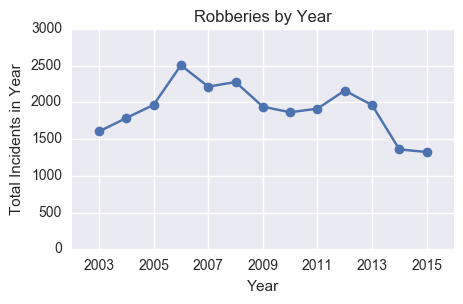

In [7]:
yearlytotal = df.year.value_counts().to_frame(name="count").sort_index()
yearlytotal['year'] = yearlytotal.index
plt.plot(yearlytotal['year'],yearlytotal['count'],'o-')
plt.xlabel('Year')
plt.ylabel('Total Incidents in Year')
plt.title(uppercase+' by Year')

if dataset == 'thefts':
    plt.axis([2002, 2016, 0, 8000])
elif dataset == 'robberies':
    plt.axis([2002, 2016, 0, 3000])
plt.xticks(range(2003,2016,2), range(2003,2016,2))
plt.tight_layout()
plt.savefig('plots/%s-yearlycounts.png' % lowercase)
plt.savefig('plots/%s-yearlycounts-transp.png' % lowercase, transparent=True)

pass

## Aggregated by month

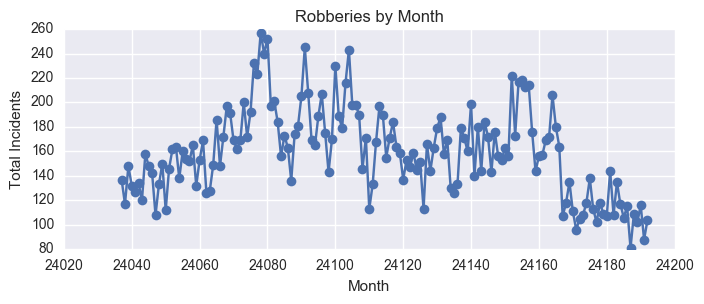

In [8]:
def monthyear2num(month,year):
    return year*12 + month

def num2monthyear(num):
    month = num % 12
    year = (num-month) / 12
    return "%.2d/%.2d" % (month,year)

groupbyyearmonth = df[['year','month']].groupby(by=['year','month']).size().to_frame(name="count")
groupbyyearmonth.reset_index(inplace=True)
groupbyyearmonth['monthyear'] = groupbyyearmonth.apply(lambda row: row['year']*12 + row['month'],axis=1)

plt.figure(figsize=(7.2,3.2))
plt.plot(groupbyyearmonth['monthyear'],groupbyyearmonth['count'],'o-')
plt.xlabel('Month')
plt.ylabel('Total Incidents')
plt.title(uppercase+' by Month')
plt.tight_layout()
pass

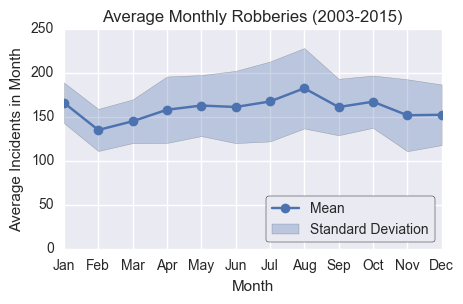

In [9]:
groupbymonth = groupbyyearmonth[['month','count']].groupby(by='month')
groupbymonth = groupbymonth['count'].agg({'sum' : sum, 'mean' : np.mean, 'std' : np.std})

plot_mean = plt.plot(groupbymonth.index,groupbymonth['mean'],'o-')
plot_std = plt.fill_between(groupbymonth.index, 
                 groupbymonth['mean']-groupbymonth['std'], 
                 groupbymonth['mean']+groupbymonth['std'],
                 alpha=.3)
plt.xlabel('Month')
plt.ylabel('Average Incidents in Month')
plt.title('Average Monthly %s (2003-2015)' % uppercase)
leg = plt.legend(['Mean','Standard Deviation'],loc='lower right')
frame = leg.get_frame()
frame.set_edgecolor('black')
if dataset == 'thefts':
    plt.axis([1, 12, 0, 700])
elif dataset == 'robberies':
    plt.axis([1, 12, 0, 250])

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(range(1,13,1), months)
plt.tight_layout()
plt.savefig('plots/%s-monthlyaverage.png' % lowercase)
plt.savefig('plots/%s-monthlyaverage-transp.png' % lowercase, transparent=True)

pass


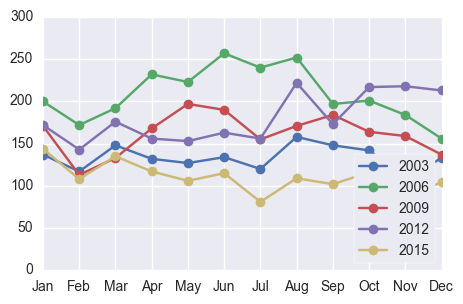

In [10]:
yearlist = [2003, 2006, 2009, 2012, 2015]
for year in yearlist:
    plt.plot(groupbyyearmonth[groupbyyearmonth.year==year]['month'],groupbyyearmonth[groupbyyearmonth.year==year]['count'],'o-')
plt.legend(yearlist,loc='lower right')
if dataset == 'thefts':
    plt.axis([1, 12, 0, 700])
elif dataset == 'robberies':
    plt.axis([1, 12, 0, 300])
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(range(1,13,1), months)
plt.tight_layout()
pass

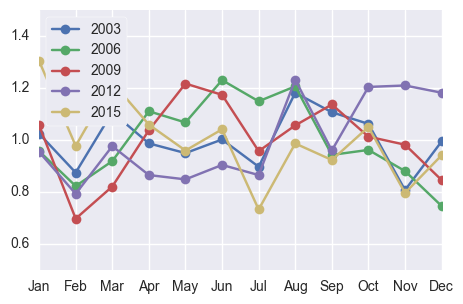

In [11]:
yearlist = [2003, 2006, 2009, 2012, 2015]
for year in yearlist:
    y = groupbyyearmonth[groupbyyearmonth.year==year]['count']/groupbyyearmonth[groupbyyearmonth.year==year]['count'].mean()
    plt.plot(groupbyyearmonth[groupbyyearmonth.year==year]['month'],y,'o-')
plt.legend(yearlist,loc='upper left')
plt.axis([1, 12, 0.5, 1.5])
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(range(1,13,1), months)
plt.tight_layout()
pass

## Daily counts over time

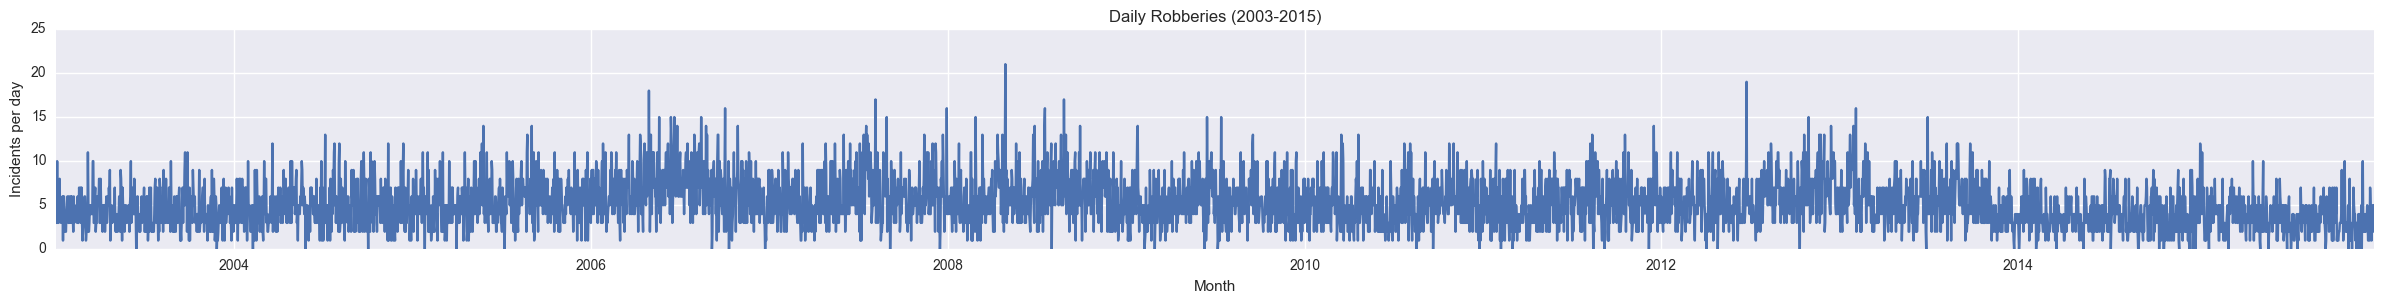

In [12]:
plt.figure(figsize=(4.8*5,3.2))
plt.plot(groupbydate['date'],groupbydate['count'],'-')
plt.xlabel('Month')
plt.ylabel('Incidents per day')
plt.title('Daily %s (2003-2015)' % uppercase)
plt.tight_layout()
pass

# Aggregated by time of day

In [13]:
def time2num(t):
    ts = t.hour * 60 + t.minute
    return ts

def scott_bw(S):
    iqr = np.subtract(*np.percentile(S, [75, 25]))
    sigma = min(S.std(),iqr)
    return 1.06*sigma*S.count()**(-0.2)

def silverman_bw(S):
    iqr = np.subtract(*np.percentile(S, [75, 25]))
    sigma = min(S.std(),iqr)
    return 0.9*sigma*S.count()**(-0.2)

class WrappedKDE:
    
    def __init__(self,S):
        # S is a pandas series
        self.bandwidth = silverman_bw(S)
        self.model = KernelDensity(bandwidth=self.bandwidth)
        return None
        
    def fit(self,data):
        self.model.fit(data.reshape(-1,1))
        return self
    
    def pdf(self,grid):
        grid = grid.reshape(-1,1)
        griddelta = grid[1]-grid[0]
        gridmax = grid[-1]+griddelta
        out = np.exp(self.model.score_samples(grid))
        out += np.exp(self.model.score_samples(grid-gridmax))
        out += np.exp(self.model.score_samples(grid+gridmax))
        return out

timekde = WrappedKDE(df.time.apply(time2num))
timekde.fit(df.time.apply(time2num))
print timekde.bandwidth
#timegrid = np.arange(1,1440,1)
#plt.scatter(timegrid, timekde.pdf(timegrid))
#plt.axis([0, 1440, 0, 0.002])

56.3635406197


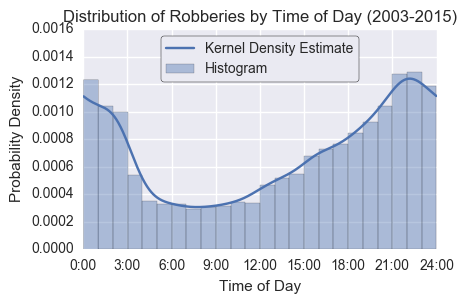

In [14]:
hours = ['0:00','3:00','6:00','9:00','12:00','15:00','18:00','21:00','24:00']
#plt.hist(df.time.apply(time2num),bins=24,normed=True,alpha=0.5)
sns.distplot(df.time.apply(time2num),kde = False,norm_hist=True,bins=24)

timegrid = np.arange(1,1440,1)
plt.plot(timegrid,timekde.pdf(timegrid),'-',color=sns.color_palette()[0])

if dataset == 'thefts':
    plt.axis([0,1440,0,0.0016])
elif dataset == 'robberies':
    plt.axis([0,1440,0,0.0016])
plt.xticks(range(0,1441,180), hours)

plt.xlabel('Time of Day')
plt.ylabel('Probability Density')
plt.title('Distribution of %s by Time of Day (2003-2015)' % uppercase)
if dataset == 'thefts':
    legloc = 'upper left'
elif dataset == 'robberies':
    legloc = 'best'
leg = plt.legend(['Kernel Density Estimate','Histogram'],loc=legloc)
frame = leg.get_frame()
frame.set_edgecolor('black')
plt.tight_layout()
plt.savefig('plots/%s-timeofdaydistribution.png' % lowercase)
plt.savefig('plots/%s-timeofdaydistribution-transp.png' % lowercase, transparent=True)

pass

# Aggregation by day of week

   dayofweekno  dayofweek       std     sum      mean  size    stderr
0            1     Monday  2.860456  3556.0  5.244838   678  0.109855
1            2    Tuesday  2.815086  3468.0  5.115044   678  0.108113
2            3  Wednesday  2.778762  3463.0  5.100147   679  0.106639
3            4   Thursday  2.652509  3438.0  5.063328   679  0.101794
4            5     Friday  2.665094  3489.0  5.146018   678  0.102352
5            6   Saturday  2.736682  3757.0  5.541298   678  0.105102
6            7     Sunday  2.749868  3718.0  5.483776   678  0.105608


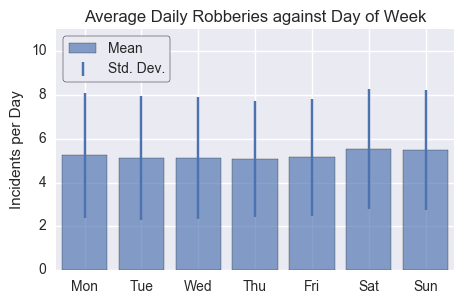

In [15]:
weekdayno ={ 
    u'Monday' : 1,
    u'Tuesday' : 2,
    u'Wednesday' : 3,
    u'Thursday' : 4,
    u'Friday' : 5,
    u'Saturday' : 6,
    u'Sunday' : 7
    }
groupbydate['dayofweekno'] = groupbydate['dayofweek'].apply(lambda x: weekdayno[x])

groupbyweekday = groupbydate.groupby(by=['dayofweekno','dayofweek'])
groupbyweekday = groupbyweekday['count'].agg({'size':'size','sum':'sum','mean':'mean','std':lambda x: np.std(x,ddof=1)})
groupbyweekday['stderr'] = groupbyweekday.apply(lambda row: row['std']/np.sqrt(row['size']),axis=1)
groupbyweekday.reset_index(inplace=True)

print groupbyweekday

weekdaylabels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

p = plt.bar(left=groupbyweekday['dayofweekno'].as_matrix(),
           height=groupbyweekday['mean'].as_matrix(),
           width=0.8,
           tick_label=weekdaylabels,
           align='center',
           yerr = groupbyweekday['std'],
           alpha=0.66)
if dataset == 'thefts':
    plt.axis([0.5,7.5,0,25])
elif dataset == 'robberies':
    plt.axis([0.5,7.5,0,11])
plt.title('Average Daily %s against Day of Week' % uppercase)
plt.ylabel('Incidents per Day')
leg = plt.legend([p,p.errorbar],['Mean','Std. Dev.'],loc='upper left')
frame = leg.get_frame()
frame.set_edgecolor('black')
plt.tight_layout()
plt.savefig('plots/%s-dayofweekaverage.png' % lowercase)
plt.savefig('plots/%s-dayofweekaverage-transp.png' % lowercase, transparent=True)

pass

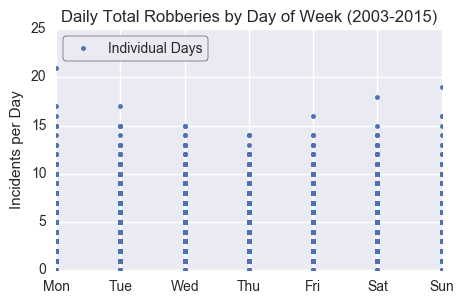

In [16]:
p = plt.plot(groupbydate['dayofweekno'],groupbydate['count'],'.')
if dataset == 'thefts':
    plt.axis([0.5,7.5,0,70])
elif dataset == 'robberies':
    pass

plt.title('Daily Total %s by Day of Week (2003-2015)' % uppercase)
plt.ylabel('Incidents per Day')
leg = plt.legend(['Individual Days'],loc='upper left')
frame = leg.get_frame()
frame.set_edgecolor('black')
plt.xticks(range(1,8,1), weekdaylabels)
plt.tight_layout()

pass

# Aggregation by spatial location

In [17]:
# Fit spatial KDE

def silverman_bwxy(df):
    count = df['x'].count()
    stdx = df['x'].std()
    stdy = df['y'].std()
    iqrx = np.subtract(*np.percentile(df['x'], [75, 25]))
    iqry = np.subtract(*np.percentile(df['y'], [75, 25]))
    sigma = min(stdx,stdy,iqrx,iqry)
    return 0.9*sigma*count**(-0.2)

spacekde = KernelDensity(bandwidth = silverman_bwxy(df[['x','y']]),metric='haversine')
spacekde.fit(df[['x','y']])


KernelDensity(algorithm='auto', atol=0, bandwidth=0.0026073070785577511,
       breadth_first=True, kernel='gaussian', leaf_size=40,
       metric='haversine', metric_params=None, rtol=0)

In [18]:
# Sample on a grid

xmin = -122.5237517
xmax = -122.3522017
ymin = 37.7040012
ymax = 37.8341382

xv, yv = np.meshgrid(np.arange(xmin,xmax,0.0004),np.arange(ymin,ymax,0.0004))
#xv, yv = np.meshgrid(np.linspace(xmin,xmax,num=400),np.linspace(ymin,ymax,num=100))

X_grid = np.vstack([xv.ravel(), yv.ravel()]).transpose()

if plot_spatialkde:

    Z = np.exp(spacekde.score_samples(X_grid))
    Zv = Z.reshape(xv.shape)

    levels = np.linspace(Zv.min(), Zv.max(), 25)
    plt.contourf(xv, yv, Zv, levels=levels, cmap=plt.cm.Reds)
    plt.title('Kernel Density Estimate of %s' % uppercase)
    plt.xlabel('Longitude')
    plt.ylabel('Lattitude')
    plt.tight_layout()
    plt.savefig('plots/%s-spatialkdeheatmap.png' % lowercase)
    plt.savefig('plots/%s-spatialkdeheatmap-transp.png' % lowercase, transparent=True)
    
    # Save sampled data to file

    Z_filt = Z/Z.max()

    tol = 1e-4
    Z_filt[abs(Z_filt) < tol] = 0.0

    out = [[point[0], point[1], point[2]] for point in zip(X_grid[:,1],X_grid[:,0],Z_filt)]

    with open("%s_kde.csv" % lowercase, "wb") as f:
        writer = csv.writer(f)
        writer.writerows(out)


# Weather

(4748, 4)


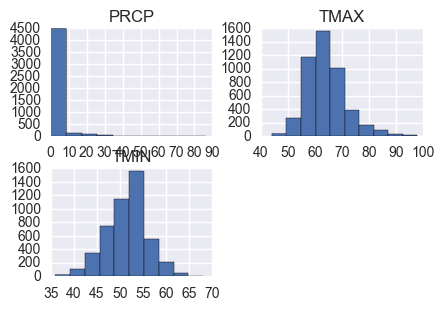

In [19]:
weather[weather.DATE < date(2016, 1, 1)].hist()
print weather[weather.DATE < date(2016, 1, 1)].shape
pass

## Aggregation by precipitation

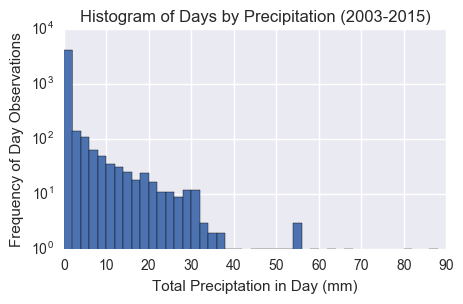

In [20]:
binsize = 2
binmin, binmax = 0, 90
plt.hist(groupbydate['PRCP'],normed=False,bins=range(0,binmax+1,binsize),log=True)

plt.xlabel('Total Preciptation in Day (mm)')
plt.ylabel('Frequency of Day Observations')
plt.title('Histogram of Days by Precipitation (2003-2015)')
plt.tight_layout()
plt.savefig('plots/precip-hist.png')
plt.savefig('plots/precip-hist-transp.png', transparent=True)

pass

               std      sum       mean  size    stderr
PRCP                                                  
[0, 2)    2.779858  21996.0   5.292589  4156  0.043121
[2, 4)    2.422539    735.0   5.212766   141  0.204015
[4, 6)    2.583647    528.0   4.800000   110  0.246341
[6, 8)    2.296060    255.0   4.047619    63  0.289276
[8, 10)   2.767818    241.0   4.820000    50  0.391429
[10, 12)  1.914647    167.0   4.638889    36  0.319108
[12, 14)  2.883397    131.0   4.225806    31  0.517873
[14, 16)  3.064855    142.0   5.680000    25  0.612971
[16, 18)  2.348689     88.0   4.888889    18  0.553591
[18, 20)  2.664854    148.0   6.166667    24  0.543961
[20, 22)  2.633215    101.0   5.941176    17  0.638649
[22, 24)  3.224903     44.0   4.000000    11  0.972345
[24, 26)  1.732051     55.0   5.000000    11  0.522233
[26, 28)  2.088327     37.0   4.111111     9  0.696109
[28, 30)  2.503028     53.0   4.416667    12  0.722562
[30, 32)  3.113996     56.0   4.666667    12  0.898933
[32, 34)  

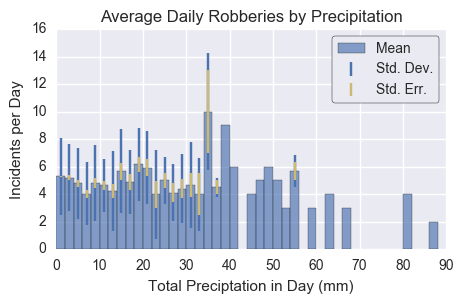

In [21]:
binsize = 2
binmin, binmax = 0, 90

groupbyprcp = groupbydate.groupby(pd.cut(groupbydate.PRCP,bins=range(0,binmax+1,binsize),right=False))
groupbyprcp = groupbyprcp['count'].agg({'size':'size','sum':'sum','mean':'mean','std':lambda x: np.std(x,ddof=1)})
groupbyprcp['stderr'] = groupbyprcp.apply(lambda row: row['std']/np.sqrt(row['size']),axis=1)
print groupbyprcp

p = plt.bar(left=np.arange(binmin,binmax,binsize),
           height=groupbyprcp['mean'].as_matrix(),
           width=binsize,
           yerr = groupbyprcp['std'],
           alpha=0.66)

# Std Error
q = plt.errorbar(np.arange(binmin,binmax,binsize)+0.5*binsize, 
             groupbyprcp['mean'].as_matrix(), 
             yerr=groupbyprcp['stderr'].as_matrix(),
             fmt='none',
             ecolor=sns.color_palette()[4]
            )

plt.xlabel('Total Preciptation in Day (mm)')
plt.ylabel('Incidents per Day')
plt.title('Average Daily %s by Precipitation' % uppercase)
leg = plt.legend([p,p.errorbar, q],['Mean','Std. Dev.','Std. Err.'],loc='upper right',frameon=True,fancybox=True)
frame = leg.get_frame()
frame.set_edgecolor('black')
if dataset == 'thefts':
    plt.axis([binmin,binmax,0,22])
elif dataset == 'robberies':
    pass

plt.tight_layout()
plt.savefig('plots/%s-precipaverage.png' % lowercase)
plt.savefig('plots/%s-precipaverage-transp.png' % lowercase, transparent=True)


0.00131381441781


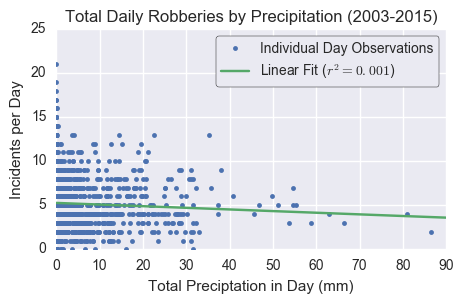

In [22]:
p = plt.plot(groupbydate['PRCP'],groupbydate['count'],'.')

# Fit linear regression
prcp_linreg = LinearRegression()
prcp_linreg.fit(groupbydate['PRCP'].as_matrix().reshape(-1, 1),groupbydate['count'].as_matrix().reshape(-1, 1))
r2 = prcp_linreg.score(groupbydate['PRCP'].as_matrix().reshape(-1, 1),groupbydate['count'].as_matrix().reshape(-1, 1))
print r2

# Plot linear regression
x = np.arange(0,91,1).reshape(-1,1)
plt.plot(x,prcp_linreg.predict(x))

plt.title('Total Daily %s by Precipitation (2003-2015)' % uppercase)
plt.xlabel('Total Preciptation in Day (mm)')
plt.ylabel('Incidents per Day')
leg = plt.legend(['Individual Day Observations','Linear Fit ($r^2 = %.3f$)' % r2],loc='upper right')
frame = leg.get_frame()
frame.set_edgecolor('black')

plt.tight_layout()
plt.savefig('plots/%s-preciplinfit.png' % lowercase)
plt.savefig('plots/%s-preciplinfit-transp.png' % lowercase, transparent=True)

pass

## Aggregation by TMAX

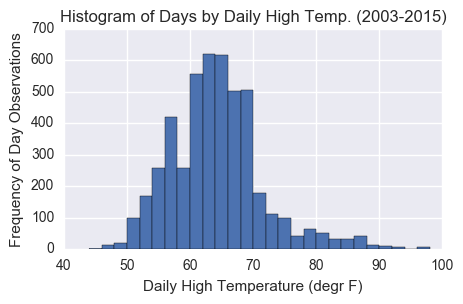

In [23]:
binsize = 2
binmin, binmax = 44, 98
plt.hist(groupbydate['TMAX'],normed=False,bins=range(binmin,binmax+1,binsize))

plt.xlabel('Daily High Temperature (degr F)')
plt.ylabel('Frequency of Day Observations')
plt.title('Histogram of Days by Daily High Temp. (2003-2015)')

plt.tight_layout()
plt.savefig('plots/tmax-hist.png')
plt.savefig('plots/tmax-hist-transp.png', transparent=True)


pass

               std     sum      mean  size    stderr
TMAX                                                
[44, 46)  0.577350    11.0  3.666667     3  0.333333
[46, 48)  3.146019    61.0  4.692308    13  0.872549
[48, 50)  2.327750   111.0  5.550000    20  0.520501
[50, 52)  2.665028   533.0  5.277228   101  0.265180
[52, 54)  2.513055   847.0  4.953216   171  0.192178
[54, 56)  2.796458  1276.0  4.926641   259  0.173763
[56, 58)  2.769629  2135.0  5.083333   420  0.135144
[58, 60)  2.708002  1374.0  5.325581   258  0.168593
[60, 62)  2.636512  2959.0  5.302867   558  0.111612
[62, 64)  2.623339  3182.0  5.115756   622  0.105186
[64, 66)  2.750460  3244.0  5.249191   618  0.110640
[66, 68)  2.957696  2702.0  5.371769   503  0.131877
[68, 70)  2.854447  2647.0  5.241584   505  0.127021
[70, 72)  2.720993   972.0  5.430168   179  0.203377
[72, 74)  3.201110   624.0  5.571429   112  0.302476
[74, 76)  2.748926   491.0  5.010204    98  0.277683
[76, 78)  3.088399   282.0  6.558140    43  0.

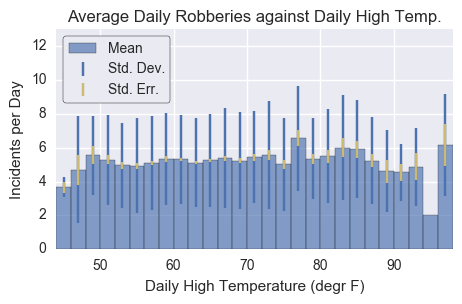

In [24]:
binsize = 2
binmin, binmax = 44, 98

#binsize = 5
#binmin, binmax = 40, 100

groupbytmax = groupbydate.groupby(pd.cut(groupbydate['TMAX'],bins=range(binmin,binmax+1,binsize),right=False))
groupbytmax = groupbytmax['count'].agg({'size':'size','sum':'sum','mean':'mean','std':lambda x: np.std(x,ddof=1)})
groupbytmax['stderr'] = groupbytmax.apply(lambda row: row['std']/np.sqrt(row['size']),axis=1)
print groupbytmax


p = plt.bar(left=np.arange(binmin,binmax,binsize),
           height=groupbytmax['mean'].as_matrix(),
           width=binsize,
           yerr = groupbytmax['std'],
           alpha=0.66)

# Std Error
q = plt.errorbar(np.arange(binmin,binmax,binsize)+0.5*binsize, 
             groupbytmax['mean'].as_matrix(), 
             yerr=groupbytmax['stderr'].as_matrix(),
             fmt='none',
             ecolor=sns.color_palette()[4]
            )

plt.xlabel('Daily High Temperature (degr F)')
plt.ylabel('Incidents per Day')
plt.title('Average Daily %s against Daily High Temp.' % uppercase)
leg = plt.legend([p,p.errorbar, q],['Mean','Std. Dev.', 'Std. Err.'],loc='upper left')
frame = leg.get_frame()
frame.set_edgecolor('black')
if dataset == 'thefts':
    plt.axis([binmin,binmax,0,29])
elif dataset == 'robberies':
    plt.axis([binmin,binmax,0,13])

plt.tight_layout()
plt.savefig('plots/%s-tmaxaverage.png' % lowercase)
plt.savefig('plots/%s-tmaxaverage-transp.png' % lowercase, transparent=True)

pass

### Linear regression

-0.18494763117


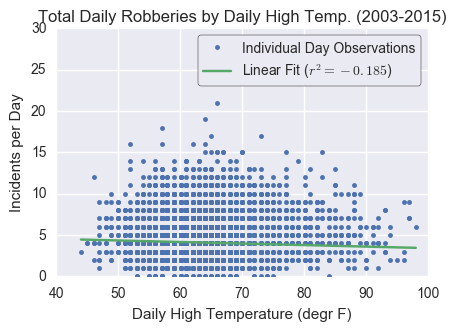

In [25]:
p = plt.plot(groupbydate['TMAX'],groupbydate['count'],'.')

# Fit linear regression
tmax_linreg = LinearRegression()
tmax_linreg.fit(groupbydate['TMAX'].as_matrix().reshape(-1, 1),groupbydate['count'].as_matrix().reshape(-1, 1))
r2 = prcp_linreg.score(groupbydate['TMAX'].as_matrix().reshape(-1, 1),groupbydate['count'].as_matrix().reshape(-1, 1))
print r2

# Plot linear regression
x = np.arange(44,99,1).reshape(-1,1)
plt.plot(x,prcp_linreg.predict(x))

plt.title('Total Daily %s by Daily High Temp. (2003-2015)' % uppercase)
plt.xlabel('Daily High Temperature (degr F)')
plt.ylabel('Incidents per Day')
leg = plt.legend(['Individual Day Observations','Linear Fit ($r^2 = %.3f$)' % r2],loc='upper right',frameon=True,fancybox=True)
frame = leg.get_frame()
frame.set_edgecolor('black')
if dataset == 'thefts':
    plt.axis([40,100,0,90])
elif dataset == 'robberies':
    plt.axis([40,100,0,30])

pass

This is no good. $r^2 = -1.5$ which means fit is worse than horizontal line.

### Parabolic regression

{'ridge__alpha': 2.0}
-0.0547582584017


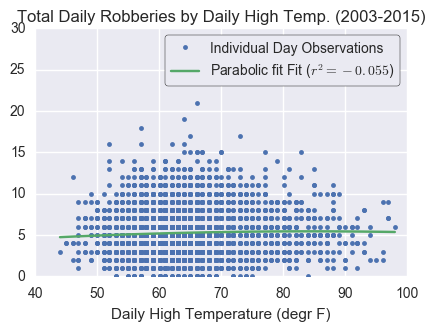

In [26]:
p = plt.plot(groupbydate['TMAX'],groupbydate['count'],'.')

# Fit polynomial regression
tmax_polypipe = Pipeline([
    ('polytrans',PolynomialFeatures(2)), 
    ('ridge',Ridge())
    ])
params = {'ridge__alpha' : np.linspace(0,2,20) }


cv = GridSearchCV(tmax_polypipe, param_grid=params)

x_dat = groupbydate['TMAX'].as_matrix().reshape(-1,1)
y_dat = groupbydate['count'].as_matrix().reshape(-1,1)
cv.fit(x_dat, y_dat)

print cv.best_params_
print cv.best_score_

x_plot = np.arange(44,99,1).reshape(-1,1)
y_plot = cv.predict(x_plot)

plt.plot(x_plot,y_plot)
plt.title('Total Daily %s by Daily High Temp. (2003-2015)' % uppercase)
plt.xlabel('Daily High Temperature (degr F)')
leg = plt.legend(['Individual Day Observations','Parabolic fit Fit ($r^2 = %.3f$)' % cv.best_score_],loc='upper right')
frame = leg.get_frame()
frame.set_edgecolor('black')
if dataset == 'thefts':
    plt.axis([40,100,0,90])
elif dataset == 'robberies':
    plt.axis([40,100,0,30])


This is no good. $r^2 = -1.5$ which means fit is worse than horizontal line.

## Aggregation by TMIN

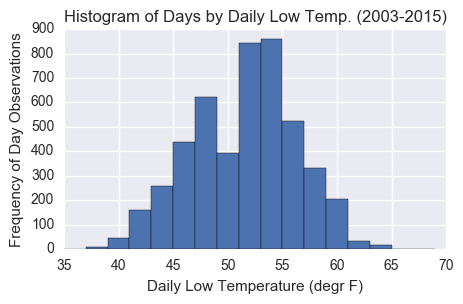

In [27]:
binsize = 2
binmin, binmax = 35, 69
plt.hist(groupbydate['TMIN'],normed=False,bins=range(binmin,binmax+1,binsize),log=False)

plt.xlabel('Daily Low Temperature (degr F)')
plt.ylabel('Frequency of Day Observations')
plt.title('Histogram of Days by Daily Low Temp. (2003-2015)')

plt.tight_layout()
plt.savefig('plots/tmin-hist.png')
plt.savefig('plots/tmin-hist-transp.png', transparent=True)

pass

               std     sum      mean  size    stderr
TMIN                                                
[35, 37)       NaN     6.0  6.000000     1       NaN
[37, 39)  2.738613    51.0  5.666667     9  0.912871
[39, 41)  2.194575   218.0  4.844444    45  0.327148
[41, 43)  2.507241   831.0  5.161491   161  0.197598
[43, 45)  2.620687  1293.0  4.973077   260  0.162528
[45, 47)  2.721750  2269.0  5.192220   437  0.130199
[47, 49)  2.711415  3152.0  5.059390   623  0.108631
[49, 51)  2.606408  1964.0  4.997455   393  0.131476
[51, 53)  2.718485  4400.0  5.225653   842  0.093685
[53, 55)  2.706858  4687.0  5.462704   858  0.092411
[55, 57)  3.047346  2918.0  5.579350   523  0.133251
[57, 59)  3.009178  1834.0  5.540785   331  0.165399
[59, 61)  2.853472   968.0  4.676329   207  0.198330
[61, 63)  2.077086   191.0  5.457143    35  0.351092
[63, 65)  1.521772    81.0  4.263158    19  0.349118
[65, 67)  4.725816    19.0  6.333333     3  2.728451
[67, 69)       NaN     7.0  7.000000     1    

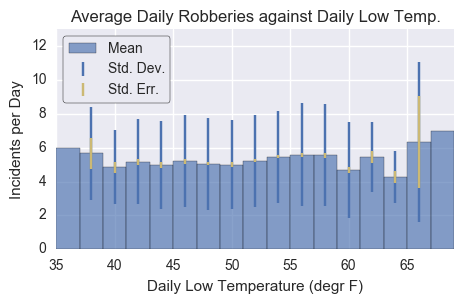

In [28]:
binsize = 2
binmin, binmax = 35, 69

#binsize = 5
#binmin, binmax = 35, 70

groupbytmin = groupbydate.groupby(pd.cut(groupbydate['TMIN'],bins=range(binmin,binmax+1,binsize),right=False))
groupbytmin = groupbytmin['count'].agg({'size':'size','sum':'sum','mean':'mean','std':lambda x: np.std(x,ddof=1)})
groupbytmin['stderr'] = groupbytmin.apply(lambda row: row['std']/np.sqrt(row['size']),axis=1)
print groupbytmin

p = plt.bar(left=np.arange(binmin,binmax,binsize),
           height=groupbytmin['mean'].as_matrix(),
           width=binsize,
           yerr = groupbytmin['std'],
           alpha=0.66)

# Std Error
q = plt.errorbar(np.arange(binmin,binmax,binsize)+0.5*binsize, 
             groupbytmin['mean'].as_matrix(), 
             yerr=groupbytmin['stderr'].as_matrix(),
             fmt='none',
             ecolor=sns.color_palette()[4]
            )

plt.xlabel('Daily Low Temperature (degr F)')
plt.ylabel('Incidents per Day')
plt.title('Average Daily %s against Daily Low Temp.' % uppercase)
leg = plt.legend([p,p.errorbar, q],['Mean','Std. Dev.', 'Std. Err.'],loc='upper left')
frame = leg.get_frame()
frame.set_edgecolor('black')
if dataset == 'thefts':
    plt.axis([binmin,binmax,0,28])
elif dataset == 'robberies':
    plt.axis([binmin,binmax,0,13])

plt.tight_layout()
plt.savefig('plots/%s-tminaverage.png' % lowercase)
plt.savefig('plots/%s-tminaverage-transp.png' % lowercase, transparent=True)

pass